In [1]:
import MDAnalysis as mda
import numpy as np

z = mda.Universe('dumpT1400.lammpsdump', atom_style='ATOMS id type xs ys zs vx vy vz')


/opt/anaconda3/lib/python3.12/site-packages/MDAnalysis/topology/LAMMPSParser.py:632: UserWarning: Guessed all Masses to 1.0
  warnings.warn('Guessed all Masses to 1.0')
/opt/anaconda3/lib/python3.12/site-packages/MDAnalysis/coordinates/LAMMPS.py:598: UserWarning: Reader has no dt information, set to 1.0 ps
  ts.data['time'] = step_num * ts.dt


# Incoherent scattering function as calculated by Dynosar based on random q-point sampling

In [8]:
import MDAnalysis as mda


from kinisi.analyze import DiffusionAnalyzer

import numpy as np
np.random.seed(42)
rng = np.random.RandomState(42)


import numpy as np
import matplotlib.pyplot as plt

from dynasor import compute_dynamic_structure_factors, Trajectory
from dynasor.qpoints import get_spherical_qpoints
from dynasor.post_processing import compute_spherical_qpoint_average


In [9]:
trajectory_filename = 'dumpT1400.lammpsdump'
traj = Trajectory(
    trajectory_filename,
    trajectory_format='lammps_internal',
    frame_stop=500)

INFO: Trajectory file: dumpT1400.lammpsdump
INFO: Total number of particles: 2048
INFO: Number of atom types: 1
INFO: Number of atoms of type X: 2048
INFO: Simulation cell (in Angstrom):
[[34.032  0.     0.   ]
 [ 0.    34.032  0.   ]
 [ 0.     0.    34.032]]


In [10]:
q_points = get_spherical_qpoints(traj.cell, q_max=2, max_points=20)

sample_raw = compute_dynamic_structure_factors(
    traj, q_points, dt=1, window_size=500,
    window_step=500, calculate_currents=True, calculate_incoherent = True)


INFO: Pruning at 0.207 < 2
INFO: Pruned from 820 q-points to 32
INFO: Spacing between samples (frame_step): 1
INFO: Time between consecutive frames in input trajectory (dt): 1 fs
INFO: Time between consecutive frames used (dt * frame_step): 1 fs
INFO: Time window size (dt * frame_step * window_size): 500.0 fs
INFO: Angular frequency resolution: dw = 0.012566 2pi/fs = 8.271 meV
INFO: Maximum angular frequency (dw * window_size): 6.283185 2pi/fs = 4135.667 meV
INFO: Nyquist angular frequency (2pi / frame_step / dt / 2): 3.142 2pi/fs = 2067.8 meV
INFO: Calculating current (velocity) correlations
INFO: Calculating incoherent part (self-part) of correlations
INFO: Number of q-points: 32


Text(0.5, 1.0, 'Incoherent Scattering - Dynasor - all q points, (q = 1.02  1/Å red)')

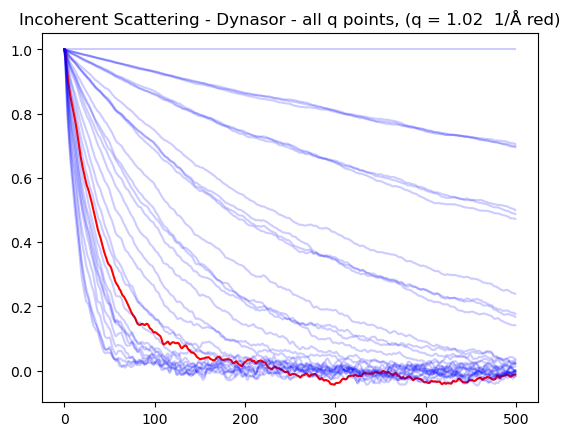

In [11]:
fig, ax = plt.subplots()

for i in range(0,len(q_points)):
    if i == 20:
        ax.plot(sample_raw.time, sample_raw.Fqt_incoh[i], 'r')
    else:
        ax.plot(sample_raw.time, sample_raw.Fqt_incoh[i], 'b', alpha = 0.2)
plt.title('Incoherent Scattering - Dynasor - all q points, (q = 1.02  1/Å red)')

In [7]:
def Incoh_F_inmem(universe: mda.Universe,
             q_points: np.ndarray,
             frame_inc: int = None,
             dt: int = 1) -> np.ndarray:
    """
    Produces the incoherent scatter function for a given mda universe as a function of dt and qpoints
    """

    # Access universe traj array
    universe.transfer_to_memory()
    cumulative_displacements = universe.trajectory.coordinate_array
    cumulative_displacements = cumulative_displacements.transpose(1, 0, 2)

    #dt = universe.trajectory.dt
    dt = np.arange(1, len(universe.trajectory), 1)
    
    if frame_inc != None:
        universe.trajectory = universe.trajectory[0:frame_inc]


    incoh_f = np.zeros((len(q_points), len(universe.trajectory)))

    for i, n in tqdm(enumerate(dt), total = len(dt)):
        mw_displacement = np.concatenate([cumulative_displacements[:, np.newaxis, i],
                                np.subtract(cumulative_displacements[:, i + 1:], cumulative_displacements[:, :-(i + 1)])],
                                axis=1)
    
        incoh_f[:,i] = np.mean(np.mean(np.exp(1j*np.einsum('ijk,lk->ijl', mw_displacement, q_points)), axis = 1), axis = 0)


    return incoh_f

In [5]:
def Incoh_F(universe: mda.Universe,
             q_points: np.ndarray,
             frame_inc: int = None,
             dt: int = 1) -> np.ndarray:
    """
    Produces the incoherent scatter function for a given mda universe as a function of dt and qpoints
    """
    universe.transfer_to_memory()
    disp = universe.trajectory.coordinate_array

    #dt = universe.trajectory.dt
    dt = np.arange(1, len(universe.trajectory), 1)
    
    if frame_inc != None:
        universe.trajectory = universe.trajectory[0:frame_inc]

    cumulative_displacements = np.zeros((len(universe.atoms), len(universe.trajectory), 3))

    

    incoh_f = np.zeros((len(q_points), len(universe.trajectory)))

    for i, n in tqdm(enumerate(dt), total = len(dt)):
        mw_displacement = np.concatenate([cumulative_displacements[:, np.newaxis, i],
                                np.subtract(cumulative_displacements[:, i + 1:], cumulative_displacements[:, :-(i + 1)])],
                                axis=1)
    
        incoh_f[:,i] = np.mean(np.mean(np.exp(1j*np.einsum('ijk,lk->ijl', mw_displacement, q_points)), axis = 1), axis = 0)


    return incoh_f
    

In [6]:
from tqdm import tqdm

incoh_f1  = Incoh_F(z, 3, 500)

/opt/anaconda3/lib/python3.12/site-packages/MDAnalysis/core/universe.py:658: UserWarning: Reader has no dt information, set to 1.0 ps
  dt=self.trajectory.ts.dt * step,


TypeError: object of type 'int' has no len()

Text(0.5, 1.0, 'dynasor implementation')

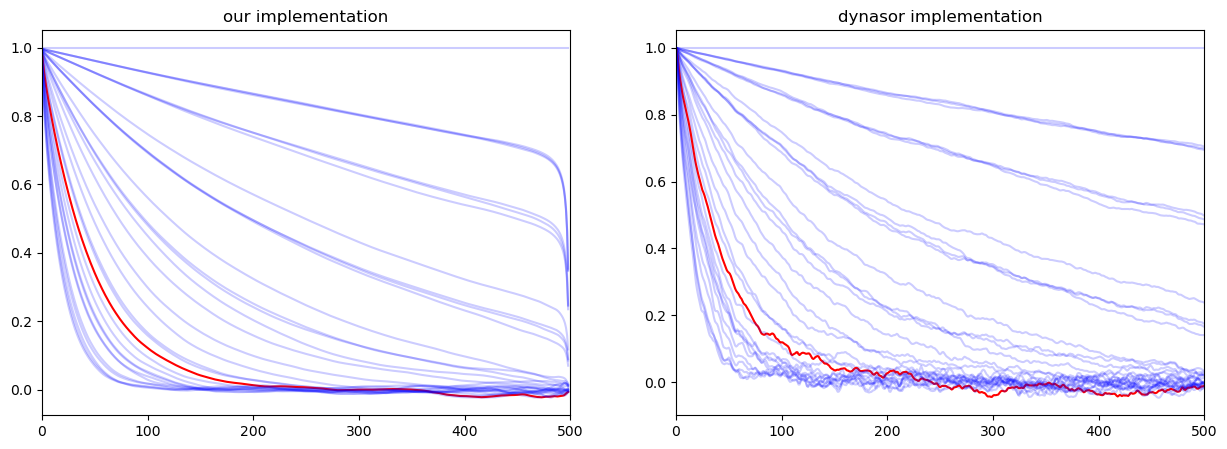

In [23]:
fig, [ax1,ax2] = plt.subplots(1,2, figsize = (15,5))

for i in range(0,len(q_points)):
    if i == 20:
        ax1.plot(incoh_f1[i].T, 'r')
        ax2.plot(sample_raw.time, sample_raw.Fqt_incoh[i], 'r')
    else:   
        ax1.plot(incoh_f1[i].T, 'b', alpha = 0.2)
        ax2.plot(sample_raw.time, sample_raw.Fqt_incoh[i], 'b', alpha = 0.2)

ax1.set_xlim(0, 500)
ax2.set_xlim(0, 500)

ax1.set_title('our implementation')
ax2.set_title('dynasor implementation')




In [58]:
# Applying to overall displacement magnitude

# Transfer to memorery and trajectory_array 

dt = np.arange(1, len(z.trajectory), 1)

cum_disp = np.zeros((2048,len(z.trajectory), 3))
int_scat = np.zeros((len(q_points),len(z.trajectory)))

for i in range(0, len(z.trajectory)):
    cum_disp[:, i, :] = z.trajectory[i]


In [67]:

from tqdm import tqdm

# Applying to overall displacement magnitude

dt = np.arange(1, len(z.trajectory), 1)

cum_disp = np.zeros((2048,len(z.trajectory), 3))
int_scat = np.zeros((len(q_points),len(z.trajectory)))

for i in range(0, len(z.trajectory)):
    cum_disp[:, i, :] = z.trajectory[i]


disp_3d = []
for i, n in tqdm(enumerate(dt), total = len(dt)):
    disp = np.concatenate([cum_disp[:, np.newaxis, i],
                            np.subtract(cum_disp[:, i + 1:], cum_disp[:, :-(i + 1)])],
                            axis=1)
    
    int_scat[:,i] = np.mean(np.mean(np.exp(1j*np.einsum('ijk,lk->ijl', disp, q_points)), axis = 1), axis = 0)

  0%|          | 0/499 [00:00<?, ?it/s]/var/folders/8y/ppth74md47d_wyx004p8vy6h0000gp/T/ipykernel_84259/3675176252.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
  int_scat[:,i] = np.mean(np.mean(np.exp(1j*np.einsum('ijk,lk->ijl', disp, q_points)), axis = 1), axis = 0)
100%|██████████| 499/499 [02:33<00:00,  3.24it/s]
